In [89]:
import numpy as np
import pandas as pd

import librosa as lr
from glob import glob


# Data Visualization
from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
#from prophet import Prophet
#from neuralprophet import NeuralProphet

# Machine Learning
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Loggers
import logging
logging.getLogger().setLevel(logging.ERROR)


# Functions

In [39]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.apply(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

In [40]:
#interpolation_type = 'linear'
#interpolate_and_plot(prices, interpolation_type)

In [41]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

    # Apply your custom function and plot
    prices_perc = prices.rolling(20).aggregate(percent_change)
    prices_perc.loc["2014":"2015"].plot()
    plt.show()

In [42]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

    # Apply your preprocessing function to the timeseries and plot the results
    prices_perc = prices_perc.apply(replace_outliers)
    prices_perc.loc["2014":"2015"].plot()
    plt.show()

# Load Data

In [43]:
# List all the wav files in the folder
audio_files = glob('./data/heart/set_a/*.wav')
len(audio_files)

176

In [44]:
# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

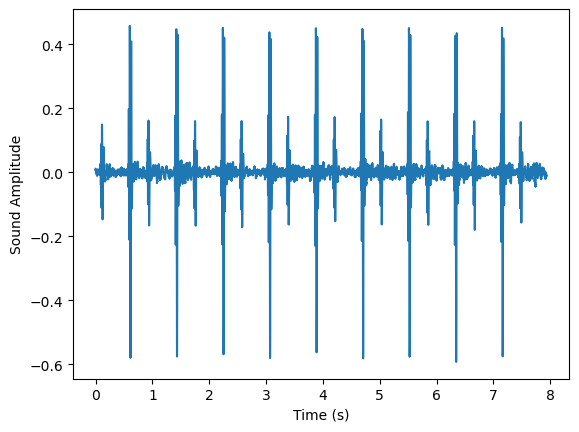

In [45]:
# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

## Features

In [46]:
audio.reshape(-1,1).shape

(174979, 1)

In [47]:
audio

array([ 0.0071146 ,  0.01133857,  0.01070743, ..., -0.00969167,
       -0.01106412, -0.00763927], dtype=float32)

In [48]:
means = np.mean(audio, axis=-1)
maxs = np.max(audio, axis=-1)
stds = np.std(audio, axis=-1)

In [49]:
X = np.column_stack([means, maxs, stds])
#y = labels.reshape(-1, 1)


In [50]:
X

array([[9.4646741e-05, 4.5713168e-01, 7.3915847e-02]], dtype=float32)

In [51]:
audio_df = np.column_stack([time, audio])
audio_df = pd.DataFrame(audio_df, columns=['time', 'freq'])
audio_df.set_index('time', inplace=True)
audio_df

,freq
time,
0.000000,0.007115
0.000045,0.011339
0.000091,0.010707
0.000136,0.011348
0.000181,0.010282
...,...
7.935329,-0.009668
7.935374,-0.010414
7.935420,-0.009692


<Axes: xlabel='time'>

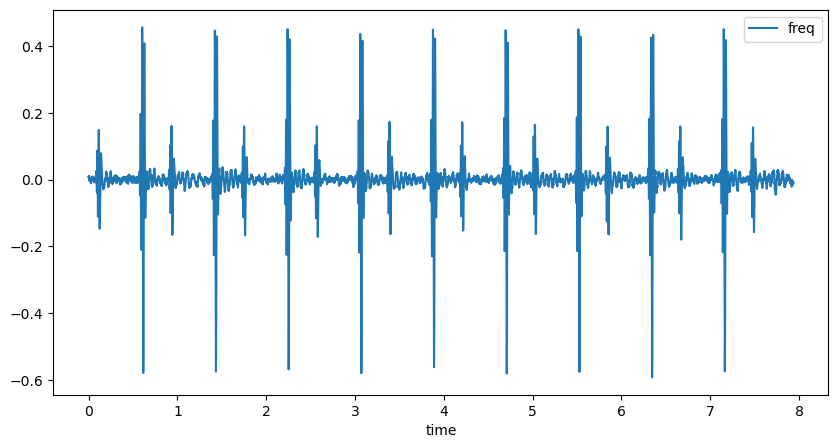

In [52]:
audio_df.plot(figsize=(10, 5))

## Rectify

In [53]:
audio_rectified = audio_df.apply(np.abs)
audio_envelope = audio_rectified.rolling(50).mean()

<Axes: xlabel='time'>

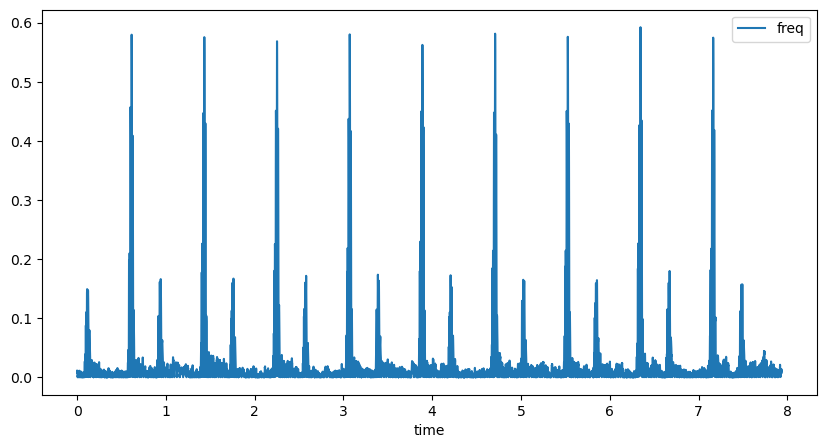

In [54]:
audio_rectified.plot(figsize=(10, 5))

# NY Stock Exchange

In [55]:
# Read in the data
data = pd.read_csv('./data/nyse/fundamentals.csv', index_col=0)

# Convert the index of the DataFrame to datetime
#data.index = pd.to_datetime(data.index)
data.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781 entries, 0 to 1780
Data columns (total 78 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ticker Symbol                                        1781 non-null   object 
 1   Period Ending                                        1781 non-null   object 
 2   Accounts Payable                                     1781 non-null   float64
 3   Accounts Receivable                                  1781 non-null   float64
 4   Add'l income/expense items                           1781 non-null   float64
 5   After Tax ROE                                        1781 non-null   float64
 6   Capital Expenditures                                 1781 non-null   float64
 7   Capital Surplus                                      1781 non-null   float64
 8   Cash Ratio                                           1482 non-null  

In [57]:
column_lst = ['Gross Profit','Net Income','Total Assets','Total Liabilities']

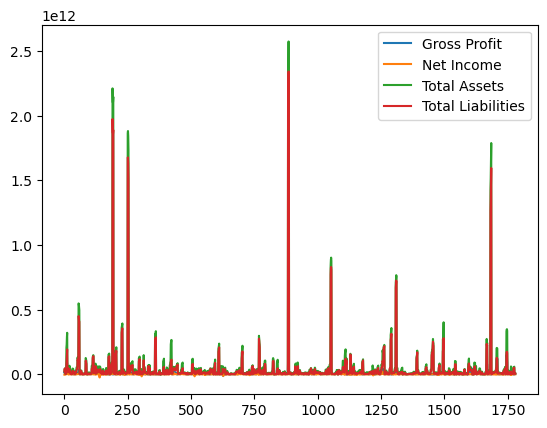

In [58]:
# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in column_lst:
    data[column].plot(ax=ax, label=column)
ax.legend()
plt.show()

# Baseball

In [59]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


sk.set_config(display='diagram')

In [60]:
# Read in the data
df = pd.read_csv('./data/Teams.csv', index_col=0)
df = df[df['franchID'] == 'NYY']

df = df[['franchID', 'G', 'Ghome', 'W', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
        'attendance']]
df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
df.drop('H', inplace=True, axis=1)
df

,franchID,G,Ghome,W,R,AB,2B,3B,HR,BB,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,1B
yearID,,,,,,,,,,,,,,,,,,,,,
1901,NYY,134,66.0,68,760,4589,179,111,24,369.0,...,3474,1313,21,344,271,401,76,0.926,141952.0,1034
1902,NYY,140,64.0,50,715,4760,202,107,33,417.0,...,3631,1531,30,354,258,357,109,0.938,174606.0,976
1903,NYY,136,67.0,72,579,4565,193,62,18,332.0,...,3604,1171,19,245,463,264,87,0.953,211808.0,863
1904,NYY,155,75.0,92,598,5220,195,91,27,312.0,...,4142,1180,29,311,684,275,90,0.958,438919.0,1041
1905,NYY,152,75.0,71,586,4957,163,61,23,360.0,...,4061,1235,26,396,642,293,88,0.952,309100.0,981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,NYY,162,81.0,91,858,5594,266,23,241,616.0,...,4346,1248,192,504,1560,95,102,0.984,3146966.0,933
2018,NYY,162,81.0,100,851,5515,269,23,267,625.0,...,4369,1311,177,494,1634,94,95,0.984,3482855.0,815
2019,NYY,162,81.0,103,943,5583,290,17,306,569.0,...,4329,1374,248,507,1534,102,135,0.982,3304404.0,880


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1901 to 2021
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   franchID    121 non-null    object 
 1   G           121 non-null    int64  
 2   Ghome       121 non-null    float64
 3   W           121 non-null    int64  
 4   R           121 non-null    int64  
 5   AB          121 non-null    int64  
 6   2B          121 non-null    int64  
 7   3B          121 non-null    int64  
 8   HR          121 non-null    int64  
 9   BB          121 non-null    float64
 10  SO          119 non-null    float64
 11  SB          121 non-null    float64
 12  RA          121 non-null    int64  
 13  ER          121 non-null    int64  
 14  ERA         121 non-null    float64
 15  CG          121 non-null    int64  
 16  SHO         121 non-null    int64  
 17  SV          121 non-null    int64  
 18  IPouts      121 non-null    int64  
 19  HA          121 non-null 

In [62]:
df.columns

Index(['franchID', 'G', 'Ghome', 'W', 'R', 'AB', '2B', '3B', 'HR', 'BB', 'SO',
       'SB', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA',
       'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', '1B'],
      dtype='object')

## Ridge Regression

In [63]:
df.sort_index(inplace=True)

In [64]:
splt_index = round(df.shape[0] * 0.8)

train_df = df[:splt_index].copy()
#train_df = train_df.resample('1D').sum()

test_df = df[splt_index:].copy()
#test_df = test_df.resample('1D').sum()

In [65]:
train_df.isnull().sum() / len(train_df)

franchID      0.000000
G             0.000000
Ghome         0.000000
W             0.000000
R             0.000000
AB            0.000000
2B            0.000000
3B            0.000000
HR            0.000000
BB            0.000000
SO            0.020619
SB            0.000000
RA            0.000000
ER            0.000000
ERA           0.000000
CG            0.000000
SHO           0.000000
SV            0.000000
IPouts        0.000000
HA            0.000000
HRA           0.000000
BBA           0.000000
SOA           0.000000
E             0.000000
DP            0.000000
FP            0.000000
attendance    0.000000
1B            0.000000
dtype: float64

## Train Dataset

In [66]:
X_train = train_df.drop(['franchID','W'], axis=1)
X_train

,G,Ghome,R,AB,2B,3B,HR,BB,SO,SB,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,1B
yearID,,,,,,,,,,,,,,,,,,,,,
1901,134,66.0,760,4589,179,111,24,369.0,373.0,207.0,...,3474,1313,21,344,271,401,76,0.926,141952.0,1034
1902,140,64.0,715,4760,202,107,33,417.0,424.0,189.0,...,3631,1531,30,354,258,357,109,0.938,174606.0,976
1903,136,67.0,579,4565,193,62,18,332.0,461.0,160.0,...,3604,1171,19,245,463,264,87,0.953,211808.0,863
1904,155,75.0,598,5220,195,91,27,312.0,552.0,163.0,...,4142,1180,29,311,684,275,90,0.958,438919.0,1041
1905,152,75.0,586,4957,163,61,23,360.0,534.0,200.0,...,4061,1235,26,396,642,293,88,0.952,309100.0,981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,162,81.0,821,5615,294,24,178,629.0,910.0,39.0,...,4315,1467,170,552,899,105,166,0.983,2416942.0,1072
1994,113,57.0,670,3986,238,16,139,530.0,660.0,55.0,...,3059,1045,120,398,656,80,122,0.982,1675556.0,762
1995,145,73.0,749,4947,280,34,122,625.0,851.0,50.0,...,3854,1286,159,535,908,74,121,0.986,1705263.0,929


In [67]:
column_lst = X_train.columns
index_lst = X_train.index

imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_trf = imp_num.fit_transform(X_train)
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = column_lst
X_train_trf.index = index_lst

In [68]:
X_train_trf.isnull().sum() / len(X_train_trf)

G             0.0
Ghome         0.0
R             0.0
AB            0.0
2B            0.0
3B            0.0
HR            0.0
BB            0.0
SO            0.0
SB            0.0
RA            0.0
ER            0.0
ERA           0.0
CG            0.0
SHO           0.0
SV            0.0
IPouts        0.0
HA            0.0
HRA           0.0
BBA           0.0
SOA           0.0
E             0.0
DP            0.0
FP            0.0
attendance    0.0
1B            0.0
dtype: float64

In [69]:
X_train_trf

,G,Ghome,R,AB,2B,3B,HR,BB,SO,SB,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,1B
yearID,,,,,,,,,,,,,,,,,,,,,
1901,134.0,66.0,760.0,4589.0,179.0,111.0,24.0,369.0,373.0,207.0,...,3474.0,1313.0,21.0,344.0,271.0,401.0,76.0,0.926,141952.0,1034.0
1902,140.0,64.0,715.0,4760.0,202.0,107.0,33.0,417.0,424.0,189.0,...,3631.0,1531.0,30.0,354.0,258.0,357.0,109.0,0.938,174606.0,976.0
1903,136.0,67.0,579.0,4565.0,193.0,62.0,18.0,332.0,461.0,160.0,...,3604.0,1171.0,19.0,245.0,463.0,264.0,87.0,0.953,211808.0,863.0
1904,155.0,75.0,598.0,5220.0,195.0,91.0,27.0,312.0,552.0,163.0,...,4142.0,1180.0,29.0,311.0,684.0,275.0,90.0,0.958,438919.0,1041.0
1905,152.0,75.0,586.0,4957.0,163.0,61.0,23.0,360.0,534.0,200.0,...,4061.0,1235.0,26.0,396.0,642.0,293.0,88.0,0.952,309100.0,981.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,162.0,81.0,821.0,5615.0,294.0,24.0,178.0,629.0,910.0,39.0,...,4315.0,1467.0,170.0,552.0,899.0,105.0,166.0,0.983,2416942.0,1072.0
1994,113.0,57.0,670.0,3986.0,238.0,16.0,139.0,530.0,660.0,55.0,...,3059.0,1045.0,120.0,398.0,656.0,80.0,122.0,0.982,1675556.0,762.0
1995,145.0,73.0,749.0,4947.0,280.0,34.0,122.0,625.0,851.0,50.0,...,3854.0,1286.0,159.0,535.0,908.0,74.0,121.0,0.986,1705263.0,929.0


In [70]:
y_train = train_df['W']
y_train

yearID
1901    68
1902    50
1903    72
1904    92
1905    71
        ..
1993    88
1994    70
1995    79
1996    92
1997    96
Name: W, Length: 97, dtype: int64

## Test Dataset

In [71]:
X_test = test_df.drop(['franchID','W'], axis=1)
y_test = test_df['W']

In [72]:
index_test_lst = X_test.index

X_test_trf = imp_num.transform(X_test)
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = column_lst
X_test_trf.index = index_test_lst

## Model

In [73]:
cmap = plt.cm.coolwarm

[Text(0.5, 0, 'Time')]

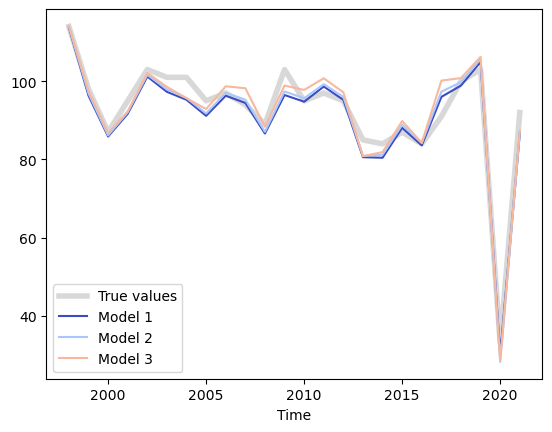

In [74]:
fig, ax = plt.subplots()

alphas = [.1, 1e2, 1e3]
ax.plot(y_test, color='Gray', alpha=.3, lw=4)
for ii, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    ridge_result = model.fit(X_train_trf, y_train)
    y_predicted = model.predict(X_test_trf)
    y_pred_df = pd.DataFrame(y_predicted)
    y_pred_df.index = y_test.index
    ax.plot(y_pred_df, c=cmap(ii / len(alphas)))
    
ax.legend(['True values', 'Model 1', 'Model 2', 'Model 3'])
ax.set(xlabel="Time")

0.9555730976128542


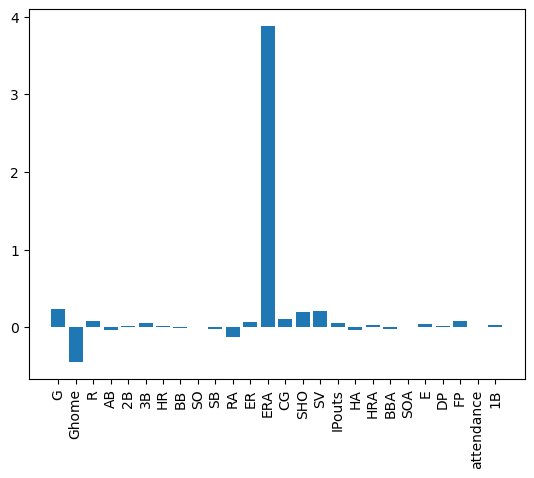

0.9595691224817539


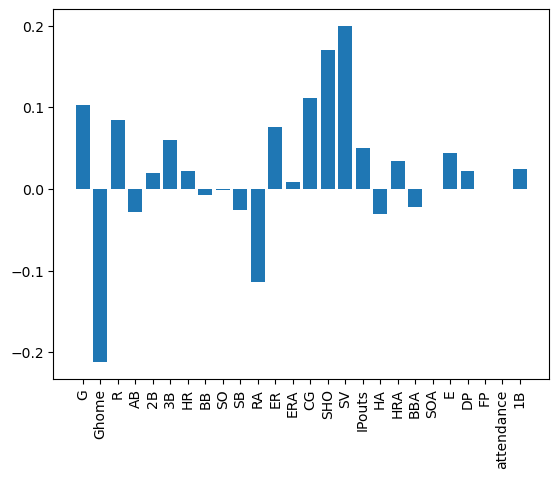

0.9510402092293557


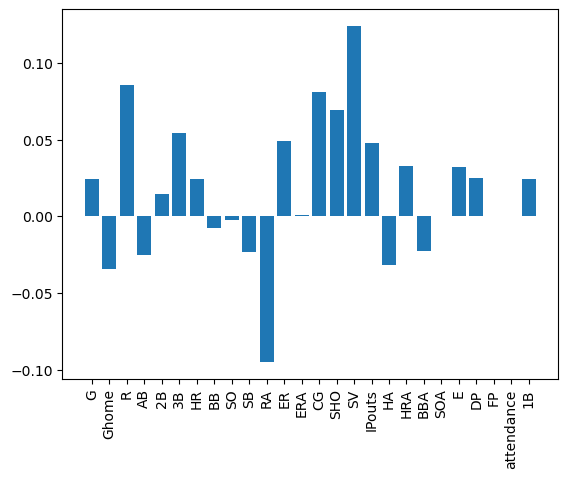

[Text(0.5, 4.444444444444445, 'Time')]

In [75]:
fig, ax = plt.subplots()

alphas = [.1, 1e2, 1e3]
for ii, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    ridge_result = model.fit(X_train_trf, y_train)
    y_predicted = model.predict(X_test_trf)
    y_pred_df = pd.DataFrame(y_predicted)
    y_pred_df.index = y_test.index    
    
    print(r2_score(y_predicted, y_test))
    plt.bar(column_lst, ridge_result.coef_)
    plt.xticks(rotation=90)
    plt.show()
     
#ax.legend(['True values', 'Model 1', 'Model 2', 'Model 3'])
ax.set(xlabel="Time")

# ARIMA

In [85]:
train_df

,franchID,G,Ghome,W,R,AB,2B,3B,HR,BB,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,1B
yearID,,,,,,,,,,,,,,,,,,,,,
1901,NYY,134,66.0,68,760,4589,179,111,24,369.0,...,3474,1313,21,344,271,401,76,0.926,141952.0,1034
1902,NYY,140,64.0,50,715,4760,202,107,33,417.0,...,3631,1531,30,354,258,357,109,0.938,174606.0,976
1903,NYY,136,67.0,72,579,4565,193,62,18,332.0,...,3604,1171,19,245,463,264,87,0.953,211808.0,863
1904,NYY,155,75.0,92,598,5220,195,91,27,312.0,...,4142,1180,29,311,684,275,90,0.958,438919.0,1041
1905,NYY,152,75.0,71,586,4957,163,61,23,360.0,...,4061,1235,26,396,642,293,88,0.952,309100.0,981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,NYY,162,81.0,88,821,5615,294,24,178,629.0,...,4315,1467,170,552,899,105,166,0.983,2416942.0,1072
1994,NYY,113,57.0,70,670,3986,238,16,139,530.0,...,3059,1045,120,398,656,80,122,0.982,1675556.0,762
1995,NYY,145,73.0,79,749,4947,280,34,122,625.0,...,3854,1286,159,535,908,74,121,0.986,1705263.0,929


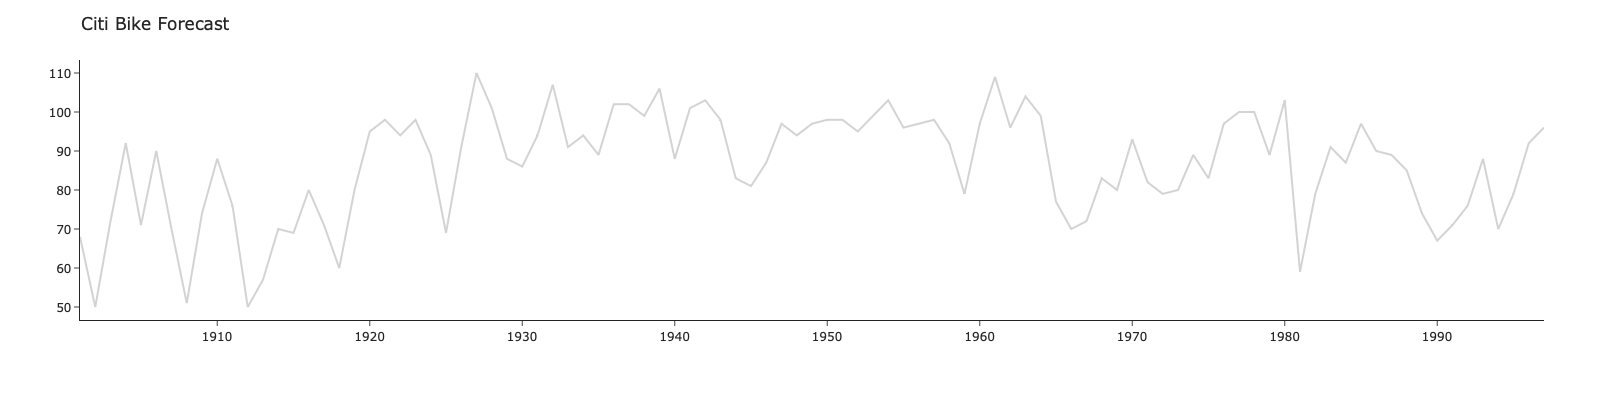

In [92]:
fig = px.line(height=400)
fig.add_scatter(y=train_df['W'], x=train_df.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.update_layout(template="simple_white", title="Citi Bike Forecast")
fig.show()

In [95]:
X_train_trf

,G,Ghome,R,AB,2B,3B,HR,BB,SO,SB,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,1B
yearID,,,,,,,,,,,,,,,,,,,,,
1901,134.0,66.0,760.0,4589.0,179.0,111.0,24.0,369.0,373.0,207.0,...,3474.0,1313.0,21.0,344.0,271.0,401.0,76.0,0.926,141952.0,1034.0
1902,140.0,64.0,715.0,4760.0,202.0,107.0,33.0,417.0,424.0,189.0,...,3631.0,1531.0,30.0,354.0,258.0,357.0,109.0,0.938,174606.0,976.0
1903,136.0,67.0,579.0,4565.0,193.0,62.0,18.0,332.0,461.0,160.0,...,3604.0,1171.0,19.0,245.0,463.0,264.0,87.0,0.953,211808.0,863.0
1904,155.0,75.0,598.0,5220.0,195.0,91.0,27.0,312.0,552.0,163.0,...,4142.0,1180.0,29.0,311.0,684.0,275.0,90.0,0.958,438919.0,1041.0
1905,152.0,75.0,586.0,4957.0,163.0,61.0,23.0,360.0,534.0,200.0,...,4061.0,1235.0,26.0,396.0,642.0,293.0,88.0,0.952,309100.0,981.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,162.0,81.0,821.0,5615.0,294.0,24.0,178.0,629.0,910.0,39.0,...,4315.0,1467.0,170.0,552.0,899.0,105.0,166.0,0.983,2416942.0,1072.0
1994,113.0,57.0,670.0,3986.0,238.0,16.0,139.0,530.0,660.0,55.0,...,3059.0,1045.0,120.0,398.0,656.0,80.0,122.0,0.982,1675556.0,762.0
1995,145.0,73.0,749.0,4947.0,280.0,34.0,122.0,625.0,851.0,50.0,...,3854.0,1286.0,159.0,535.0,908.0,74.0,121.0,0.986,1705263.0,929.0


In [114]:
min(y_df.index)

1901

In [115]:
max(y_df.index)

1997

In [139]:
pidx = pd.date_range(start=str(min(y_df.index)), end=str(max(y_df.index)), inclusive="both", freq='AS')
pidx

DatetimeIndex(['1901-01-01', '1902-01-01', '1903-01-01', '1904-01-01',
               '1905-01-01', '1906-01-01', '1907-01-01', '1908-01-01',
               '1909-01-01', '1910-01-01', '1911-01-01', '1912-01-01',
               '1913-01-01', '1914-01-01', '1915-01-01', '1916-01-01',
               '1917-01-01', '1918-01-01', '1919-01-01', '1920-01-01',
               '1921-01-01', '1922-01-01', '1923-01-01', '1924-01-01',
               '1925-01-01', '1926-01-01', '1927-01-01', '1928-01-01',
               '1929-01-01', '1930-01-01', '1931-01-01', '1932-01-01',
               '1933-01-01', '1934-01-01', '1935-01-01', '1936-01-01',
               '1937-01-01', '1938-01-01', '1939-01-01', '1940-01-01',
               '1941-01-01', '1942-01-01', '1943-01-01', '1944-01-01',
               '1945-01-01', '1946-01-01', '1947-01-01', '1948-01-01',
               '1949-01-01', '1950-01-01', '1951-01-01', '1952-01-01',
               '1953-01-01', '1954-01-01', '1955-01-01', '1956-01-01',
      

In [140]:
y_df = pd.DataFrame(y_train)
pidx = pd.date_range(start=str(min(y_df.index)), end=str(max(y_df.index)), inclusive="both", freq='AS')
y_df.set_index(pidx, inplace=True)
y_df

,W
1901-01-01,68
1902-01-01,50
1903-01-01,72
1904-01-01,92
1905-01-01,71
...,...
1993-01-01,88
1994-01-01,70
1995-01-01,79
1996-01-01,92


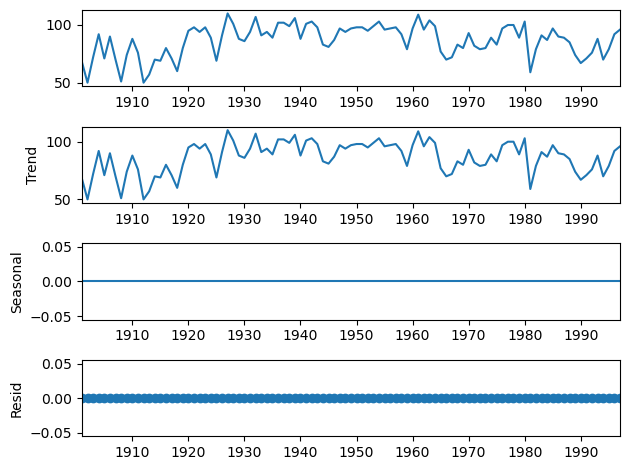

In [141]:
decomposition = sm.tsa.seasonal_decompose(y_df)
fig = decomposition.plot()

# Stats Model

In [199]:
# Add a constant column to X to represent the intercept in the model
X_train_sm = sm.add_constant(X_train_trf)

In [200]:
ols_model = sm.OLS(y_train, X_train_sm)
ols_result = ols_model.fit()

In [201]:
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     54.49
Date:                Sun, 16 Jul 2023   Prob (F-statistic):           1.06e-36
Time:                        15:32:45   Log-Likelihood:                -242.75
No. Observations:                  97   AIC:                             539.5
Df Residuals:                      70   BIC:                             609.0
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -133.8323    408.050     -0.328      0.7

## Predict

In [202]:
train_pred = ols_result.predict(X_train_sm)
train_pred

yearID
1901    64.858201
1902    55.147388
1903    67.288655
1904    90.734393
1905    74.427231
          ...    
1993    86.501085
1994    68.242339
1995    78.505952
1996    89.932311
1997    98.604823
Length: 97, dtype: float64

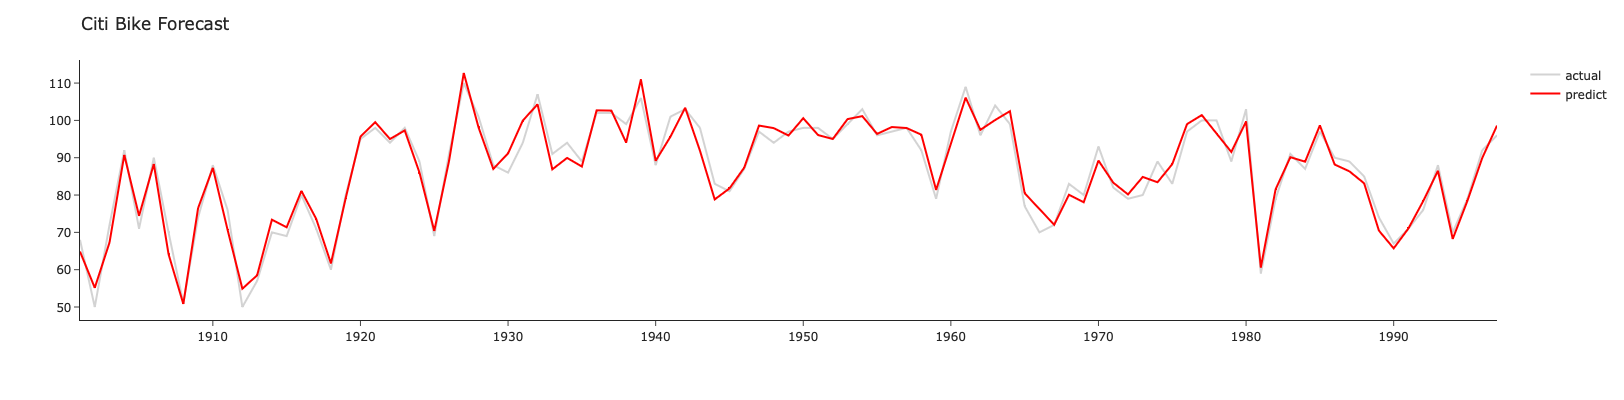

In [208]:
fig = px.line(height=400)
fig.add_scatter(y=train_df['W'], x=train_df.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=train_pred, x=train_df.index,
                marker=dict(size=20, color="red"), name='predict')
fig.update_layout(template="simple_white", title="Citi Bike Forecast")
fig.show()

In [210]:
# Add a constant column to X to represent the intercept in the model
X_test_sm = sm.add_constant(X_test_trf)

In [213]:
test_pred = ols_result.predict(X_test_sm)

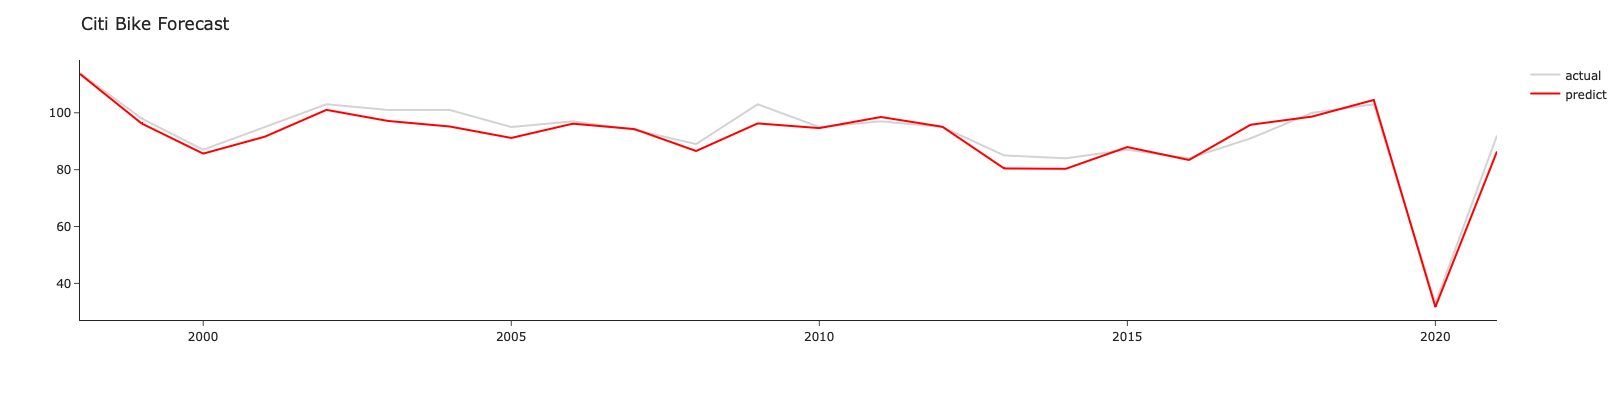

In [219]:
fig = px.line(height=400)
fig.add_scatter(y=test_df['W'], x=test_df.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=test_pred, x=test_pred.index,
                marker=dict(size=20, color="red"), name='predict')
fig.update_layout(template="simple_white", title="Citi Bike Forecast")
fig.show()